In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.optimize import fsolve

In [48]:
'''

Find the roots of the viscoelastic dynamic beam equation with numpy.roots

'''

# define function to get coefficients 
def get_coefficients(H_i,xi,eta):
    
    # define material properties, elastic moduli, and viscosity (calculated assuming eta = 6 bar*year)
    rho_i = 910
    rho_w = 1000
    H_w = H_i*rho_i/rho_w
    g = 9.8
    E = 1e9
    nu = 0.3
    lamb = (E*nu)/(1+nu)/(1-2*nu)
    mu = E/2/(1+nu)
    M = lamb + 2*mu
    k = lamb + (2/3)*mu
    t_m = eta/mu

    # define parameter groups
    gamma = 1/np.tanh(H_w*xi)/xi;
    B = rho_i*H_i + rho_w*gamma

    # write the coefficients for the polynomial equation- index corresponds to the degree of each monomial term with respect to s 
    c_4 = M*B
    c_3 = B*(1/t_m)*(M+k)
    c_2 = B*k*(1/t_m)**2 + M*rho_w*g + (1/3)*(H_i**3)*(xi**4)*mu*(mu+lamb)
    c_1 = (1/t_m)*(rho_w*g*(M+k) + (1/3)*(H_i**3)*(xi**4)*mu*k)
    c_0 = rho_w*g*k*(1/t_m)**2
    coefficients = [c_4,c_3,c_2,c_1,c_0]
    
    return coefficients

# set ice shelf geometry (length is used to lowest wavenumber)
H_i = 500
L = 7e4

# define a range of wavenumbers
xi_vect = np.logspace(-6,np.log10(100/H_i),100)

# define a range of viscosities
log_eta_vect = [14]
E = 1e9

# iterate through wavenumber vector and find roots
roots = []
for log_eta in log_eta_vect:
    roots_eta = []
    for xi in xi_vect:
        coefficients = get_coefficients(H_i,xi,10**log_eta)
        roots_eta.append(np.roots(coefficients))
    roots.append(np.transpose(roots_eta))
roots = np.array(roots)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


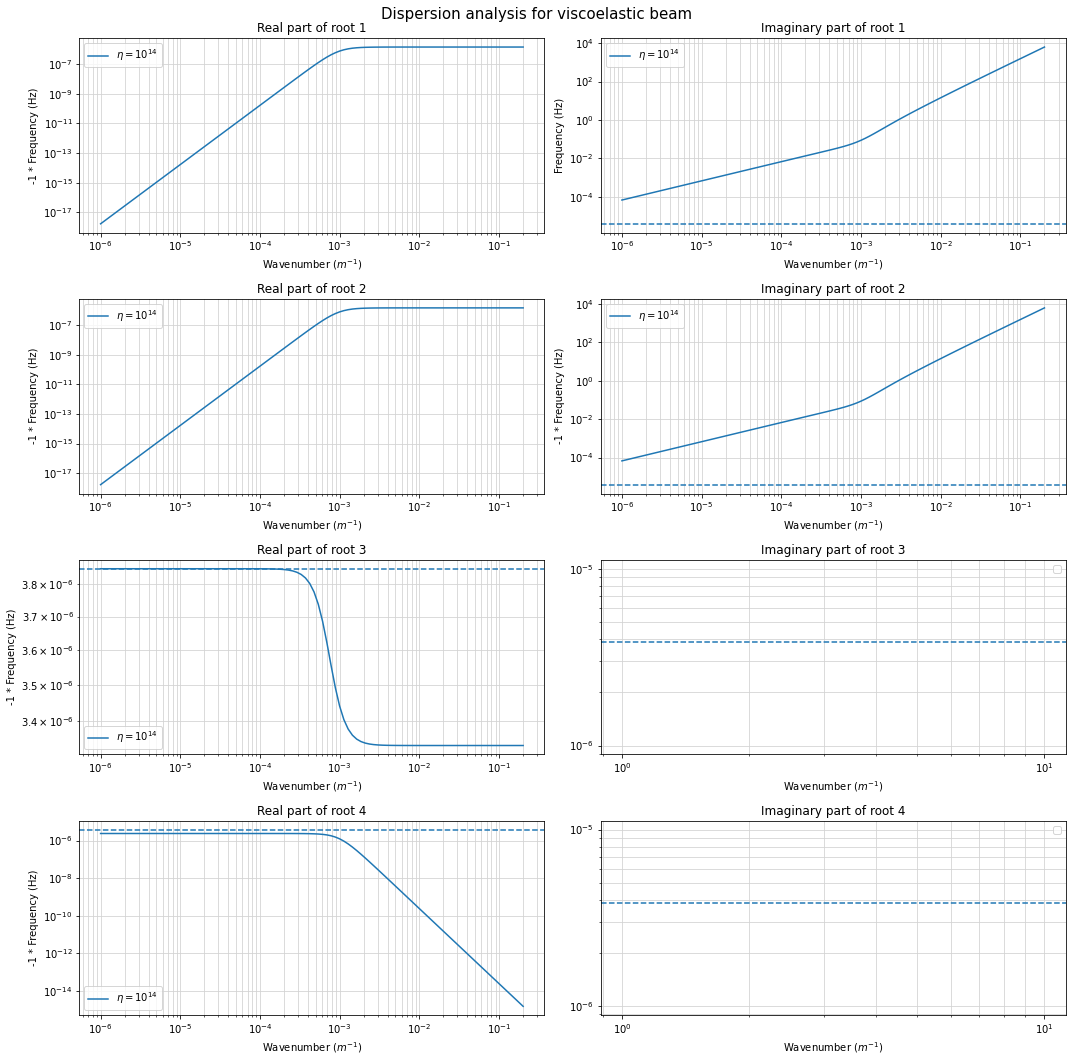

In [49]:
'''

Dispersion analysis of the system

'''

# plot each root
fig,ax = plt.subplots(4,2,figsize=(15,15))
for i in range(roots.shape[1]):
    for j in range(roots.shape[0]):
        
        # plot real roots, multiplying by -1 if negative
        if np.max(roots[j,i,:].real) > 0:
            ax[i,0].plot(xi_vect,roots[j,i,:].real,label="$\eta=10^{"+str(log_eta_vect[j])+"}$")
            ax[i,0].set_ylabel('Frequency (Hz)')
        elif np.max(roots[j,i,:].real) < 0:
            ax[i,0].plot(xi_vect,-1*roots[j,i,:].real,label="$\eta=10^{"+str(log_eta_vect[j])+"}$")
            ax[i,0].set_ylabel('-1 * Frequency (Hz)')

        # plot imaginary roots, multiplying by -1 if negative
        if np.max(roots[j,i,:].imag) > 0 or np.max(roots[j,i,:].real) == 0:
            ax[i,1].plot(xi_vect,roots[j,i,:].imag,label="$\eta=10^{"+str(log_eta_vect[j])+"}$")
            ax[i,1].set_ylabel('Frequency (Hz)')
        elif np.max(roots[j,i,:].imag) < 0:
            ax[i,1].plot(xi_vect,-1*roots[j,i,:].imag,label="$\eta=10^{"+str(log_eta_vect[j])+"}$")
            ax[i,1].set_ylabel('-1 * Frequency (Hz)')
        elif np.max(roots[j,i,:].imag) == 0:
            ax[i,0].axhline(y=(E/2/(1+0.3))/(10**log_eta_vect[j]),linestyle='--',c=colors[j])

        # configure labels
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        for k in range(ax.shape[1]):
            ax[i,k].set_xscale('log')
            ax[i,k].set_yscale('log')
            ax[i,k].set_xlabel('Wavenumber ($m^{-1}$)')
            ax[i,k].grid(which='both',color='lightgrey')
            ax[i,k].legend()
        ax[i,1].axhline(y=(E/2/(1+0.3))/(10**log_eta_vect[j]),linestyle='--',c=colors[j])
        ax[i,0].set_title('Real part of root '+str(i+1))
        ax[i,1].set_title('Imaginary part of root '+str(i+1))
plt.suptitle("Dispersion analysis for viscoelastic beam",size=15)
plt.tight_layout()

/Users/steph/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/steph/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/steph/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/steph/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


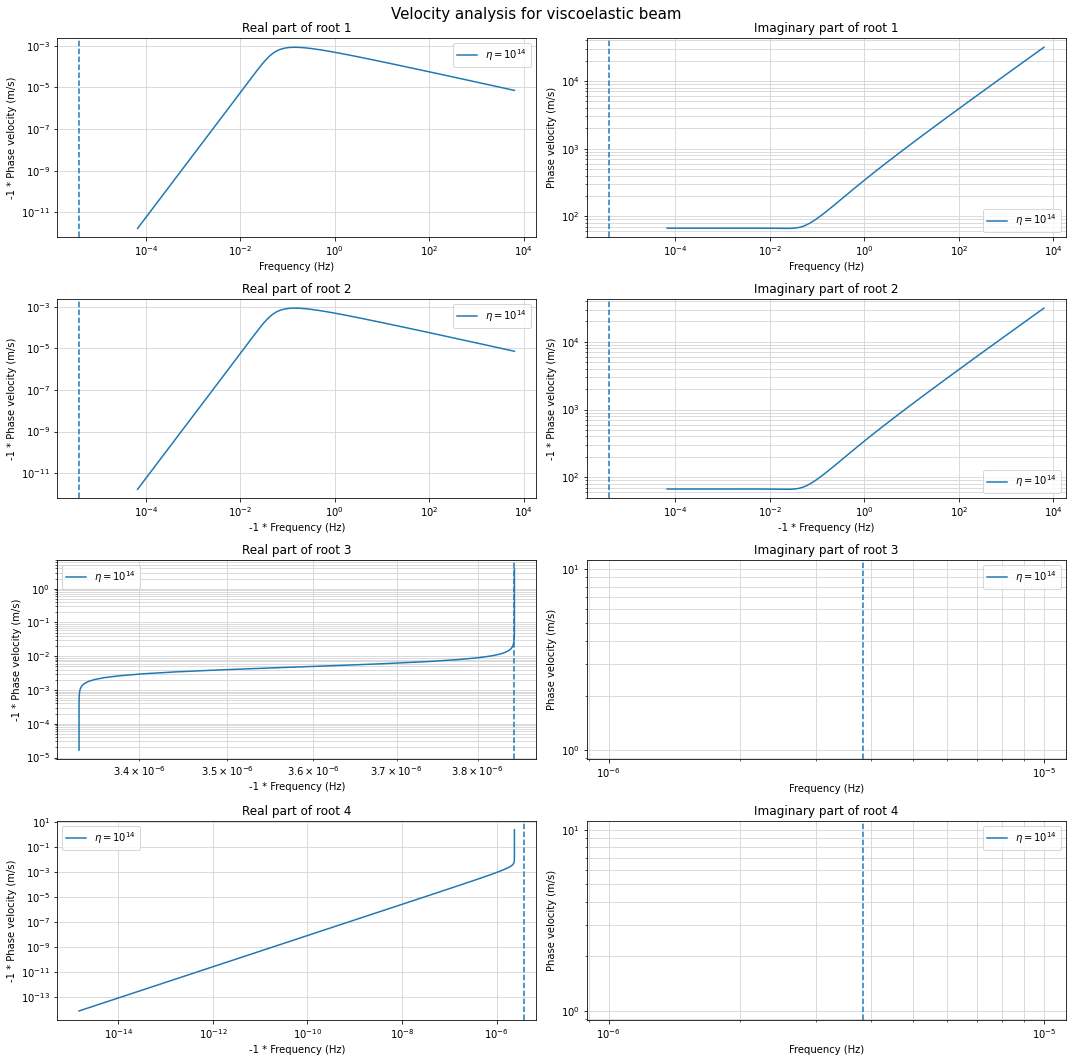

In [50]:
'''

Velocity analysis of the system

'''

# plot phase velocities 
fig,ax = plt.subplots(4,2,figsize=(15,15))
for i in range(roots.shape[1]):
    for j in range(roots.shape[0]):    
        
        # plot real roots, multiplying by -1 if negative
        if np.max(roots[j,i,:].real) > 0:
            ax[i,0].plot(roots[j,i,:].imag,roots[j,i,:].real/xi_vect,label="$\eta=10^{"+str(log_eta_vect[j])+"}$")
            ax[i,0].set_xlabel('Frequency (Hz)')
            ax[i,0].set_ylabel('Phase velocity (m/s)')
        elif np.max(roots[j,i,:].real) < 0 and np.max(roots[j,i,:].imag) > 0:
            ax[i,0].plot(roots[j,i,:].imag,-1*roots[j,i,:].real/xi_vect,label="$\eta=10^{"+str(log_eta_vect[j])+"}$")
            ax[i,0].set_xlabel('Frequency (Hz)')
            ax[i,0].set_ylabel('-1 * Phase velocity (m/s)')
        elif np.max(roots[j,i,:].real) < 0 and np.max(roots[j,i,:].imag) < 0:
            ax[i,0].plot(-1*roots[j,i,:].imag,-1*roots[j,i,:].real/xi_vect,label="$\eta=10^{"+str(log_eta_vect[j])+"}$")
            ax[i,0].set_xlabel('-1 * Frequency (Hz)')
            ax[i,0].set_ylabel('-1 * Phase velocity (m/s)')
        elif np.max(roots[j,i,:].real) < 0 and np.max(roots[j,i,:].imag) == 0:
            ax[i,0].plot(-1*roots[j,i,:].real,-1*roots[j,i,:].real/xi_vect,label="$\eta=10^{"+str(log_eta_vect[j])+"}$")
            ax[i,0].set_xlabel('-1 * Frequency (Hz)')
            ax[i,0].set_ylabel('-1 * Phase velocity (m/s)')

        # plot imaginary roots, multiplying by -1 if negative
        if np.max(roots[j,i,:].imag) > 0 or np.max(roots[j,i,:].imag) == 0:
            ax[i,1].plot(roots[j,i,:].imag,roots[j,i,:].imag/xi_vect,label="$\eta=10^{"+str(log_eta_vect[j])+"}$")
            ax[i,1].set_xlabel('Frequency (Hz)')
            ax[i,1].set_ylabel('Phase velocity (m/s)')
        elif np.max(roots[j,i,:].imag) < 0:
            ax[i,1].plot(-1*roots[j,i,:].imag,-1*roots[j,i,:].imag/xi_vect,label="$\eta=10^{"+str(log_eta_vect[j])+"}$")
            ax[i,1].set_xlabel('-1 * Frequency (Hz)')
            ax[i,1].set_ylabel('-1 * Phase velocity (m/s)')

        # configure labels
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        for k in range(ax.shape[1]):
            ax[i,k].set_xscale('log')
            ax[i,k].set_yscale('log')
            ax[i,k].grid(which='both',color='lightgrey')
            ax[i,k].legend()
            ax[i,k].axvline(x=(E/2/(1+0.3))/(10**log_eta_vect[j]),linestyle='--',c=colors[j])
        ax[i,0].set_title('Real part of root '+str(i+1))
        ax[i,1].set_title('Imaginary part of root '+str(i+1))
plt.suptitle("Velocity analysis for viscoelastic beam",size=15)
plt.tight_layout()

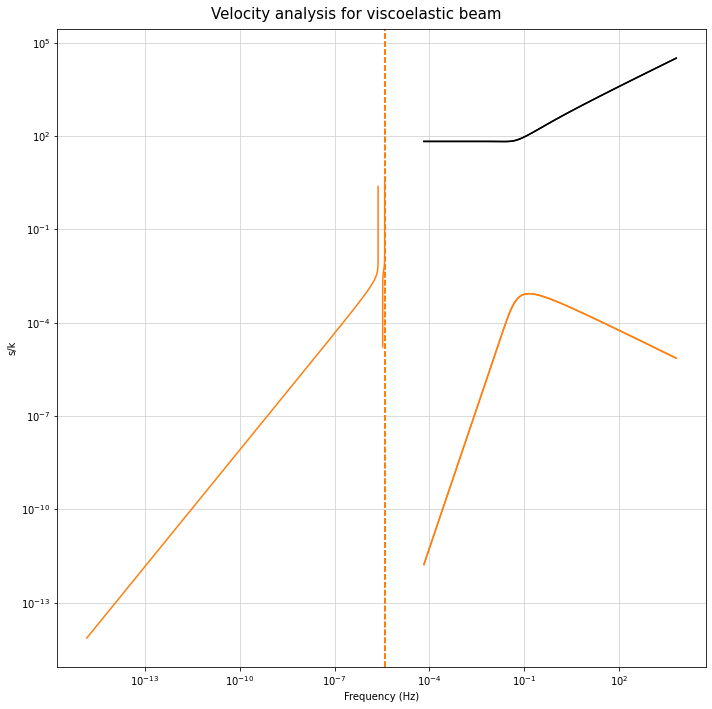

In [51]:
'''

Velocity analysis of the system

'''

# plot phase velocities 
fig,ax = plt.subplots(1,1,figsize=(10,10))
for i in range(roots.shape[1]):
    for j in range(roots.shape[0]):    
        
        # plot real roots, multiplying by -1 if negative
        if np.max(roots[j,i,:].real) > 0:
            ax.plot(roots[j,i,:].imag,roots[j,i,:].real/xi_vect,label="$\eta=10^{"+str(log_eta_vect[j])+"}$",c="C1")
            ax.set_xlabel('Frequency (Hz)')
            #ax.set_ylabel('Phase velocity (m/s)')
        elif np.max(roots[j,i,:].real) < 0 and np.max(roots[j,i,:].imag) > 0:
            ax.plot(roots[j,i,:].imag,-1*roots[j,i,:].real/xi_vect,label="$\eta=10^{"+str(log_eta_vect[j])+"}$",c="C1")
            ax.set_xlabel('Frequency (Hz)')
            #ax.set_ylabel('-1 * Phase velocity (m/s)')
        elif np.max(roots[j,i,:].real) < 0 and np.max(roots[j,i,:].imag) < 0:
            ax.plot(-1*roots[j,i,:].imag,-1*roots[j,i,:].real/xi_vect,label="$\eta=10^{"+str(log_eta_vect[j])+"}$",c="C1")
            ax.set_xlabel('-1 * Frequency (Hz)')
            #ax.set_ylabel('-1 * Phase velocity (m/s)')
        elif np.max(roots[j,i,:].real) < 0 and np.max(roots[j,i,:].imag) == 0:
            ax.plot(-1*roots[j,i,:].real,-1*roots[j,i,:].real/xi_vect,label="$\eta=10^{"+str(log_eta_vect[j])+"}$",c="C1")
            ax.set_xlabel('-1 * Frequency (Hz)')
            #ax.set_ylabel('-1 * Phase velocity (m/s)')

        # plot imaginary roots, multiplying by -1 if negative
        if np.max(roots[j,i,:].imag) > 0 or np.max(roots[j,i,:].imag) == 0:
            ax.plot(roots[j,i,:].imag,roots[j,i,:].imag/xi_vect,label="$\eta=10^{"+str(log_eta_vect[j])+"}$",c='k')
            ax.set_xlabel('Frequency (Hz)')
        elif np.max(roots[j,i,:].imag) < 0:
            ax.plot(-1*roots[j,i,:].imag,-1*roots[j,i,:].imag/xi_vect,label="$\eta=10^{"+str(log_eta_vect[j])+"}$",c='k')
            ax.set_xlabel('-1 * Frequency (Hz)')
            #ax.set_ylabel('-1 * Phase velocity (m/s)')

        # configure labels
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        ax.set_ylabel('s/k')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.grid(which='both',color='lightgrey')
        #ax.legend()
        ax.axvline(x=(E/2/(1+0.3))/(10**log_eta_vect[j]),linestyle='--',c='C1')
        #ax.set_title('Real part of root '+str(i+1))
        #ax.set_title('Imaginary part of root '+str(i+1))
plt.suptitle("Velocity analysis for viscoelastic beam",size=15)
plt.tight_layout()

/Users/steph/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/steph/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/steph/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/steph/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


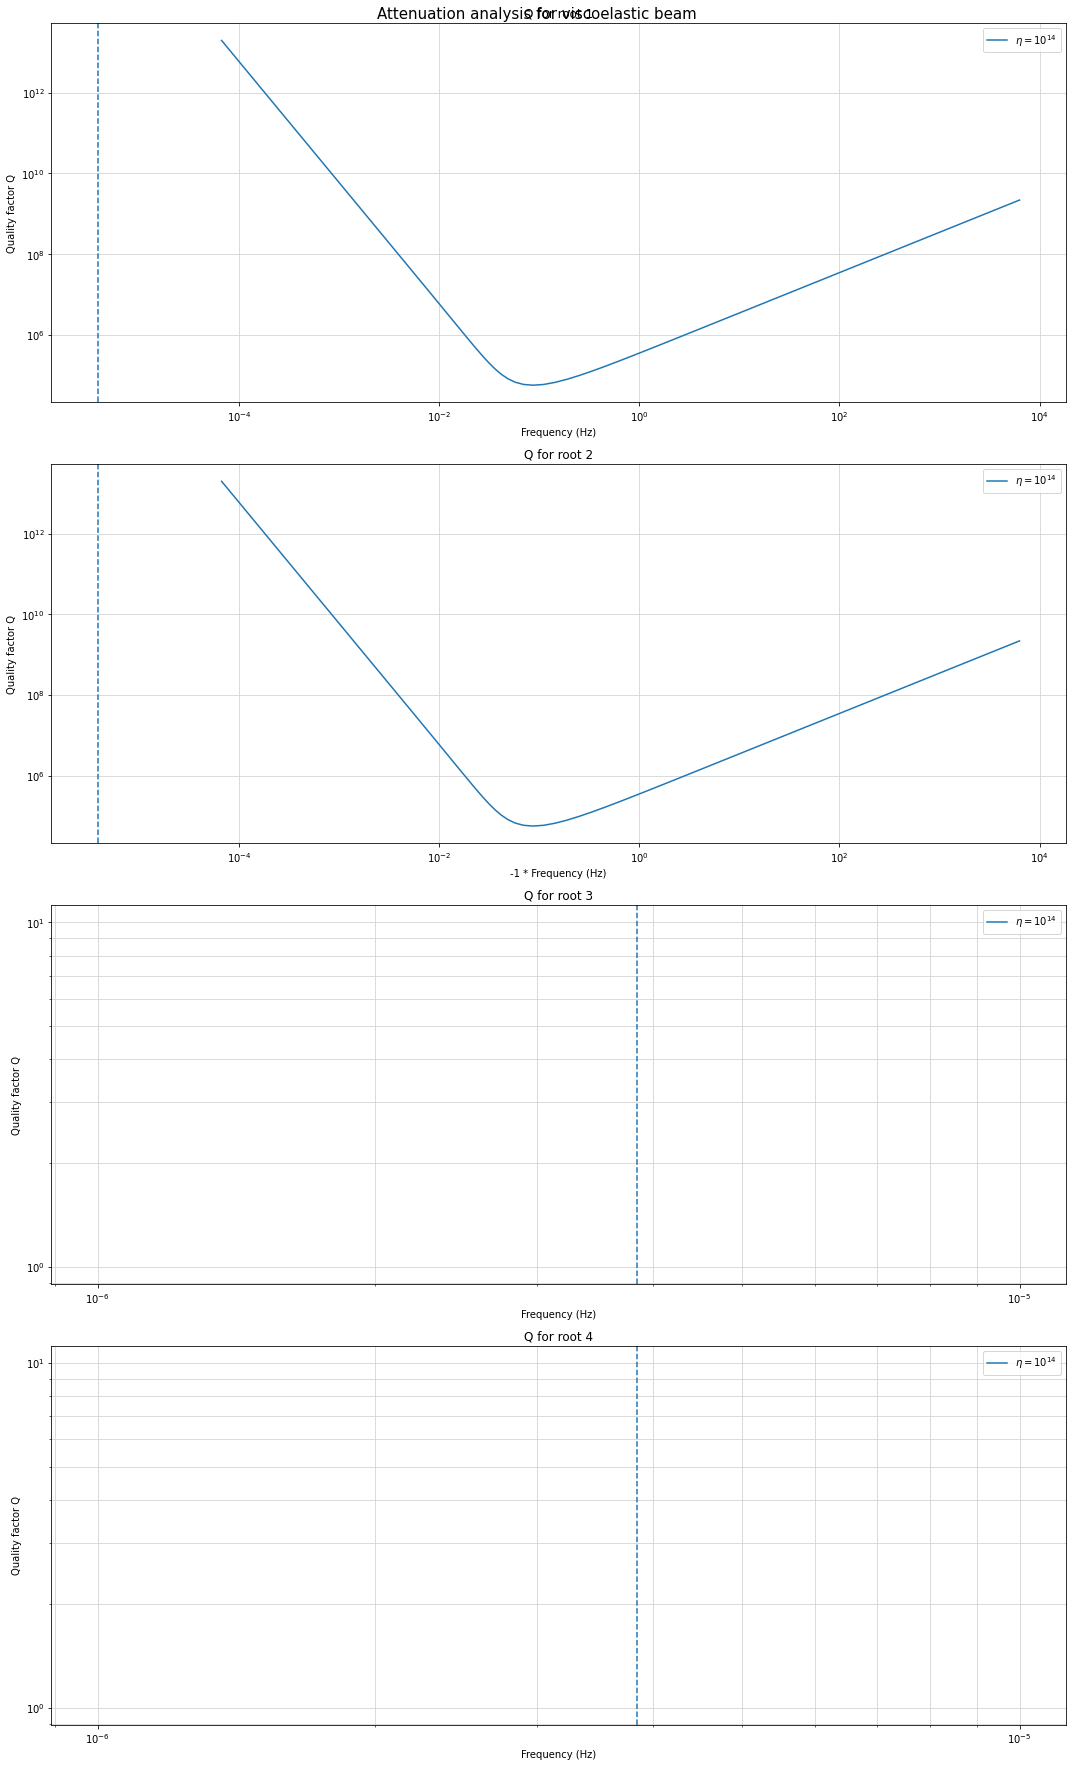

In [52]:
'''

Attenuation analysis of the system

'''

# get complex-valued roots
complex_roots = roots[:,np.iscomplex(roots[0,:])]

# plot phase velocities 
fig,ax = plt.subplots(4,1,figsize=(15,25))
for i in range(roots.shape[1]):
    for j in range(roots.shape[0]):    

        # plot quality factor Q
        if np.max(roots[j,i,:].imag) < 0:
            ax[i].plot(-1*roots[j,i,:].imag,np.abs(roots[j,i,:].imag/roots[j,i,:].real/2),label="$\eta=10^{"+str(log_eta_vect[j])+"}$")
            ax[i].set_xlabel('-1 * Frequency (Hz)')
            ax[i].set_ylabel('Quality factor Q')
        else:
            ax[i].plot(roots[j,i,:].imag,np.abs(roots[j,i,:].imag/roots[j,i,:].real/2),label="$\eta=10^{"+str(log_eta_vect[j])+"}$")
            ax[i].set_xlabel('Frequency (Hz)')
            ax[i].set_ylabel('Quality factor Q')

        # configure labels
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].grid(which='both',color='lightgrey')
        ax[i].set_title('Q for root '+str(i+1))
        ax[i].legend()
        ax[i].axvline(x=(E/2/(1+0.3))/(10**log_eta_vect[j]),linestyle='--',c=colors[j])

plt.suptitle("Attenuation analysis for viscoelastic beam",size=15)
plt.tight_layout()